# Load WeatherBench2

The code is based on https://weatherbench2.readthedocs.io/en/latest/evaluation.html. 

Before running the code, create a conda environment and download required packages using the commandline arguments below.
 
- Create a conda environment
    ```bash
    conda create --name climate python=3.11
    conda activate climate
    ``` 
- Install requird packages e.g., [xarray](https://xarray.pydata.org/en/v0.9.2/installing.html). Note: Installing `xarray` automatically installs required dependencies including [numpy](https://numpy.org) and [pandas](https://pandas.pydata.org).
    ```bash
    conda install xarray==2023.6.0  
    conda install -c conda-forge zarr==2.15.0
    conda install -c conda-forge fsspec # `fsspec` is required to use zarr's FSStore
    conda install -c conda-forge gcsfs # to access Google Storage 
    conda install dask -c conda-forge # visualize vector shape for xarray
    conda install matplotlib # visualize dataset
    ``` 
- Choose `climate` as the environment to run this notebook.

In [54]:
import xarray as xr 
import matplotlib.pyplot as plt


## Load ERA5 file 
We load an example file that stores the reanalysis data ERA5 with spatial resolution 5.625 degree (64 x 32 grid) at 13 vertical levels.

This dataset contains 92044 timestamps of weather snapshots, each containing 38 variables. The variables have three distinct shapes: 
1. (64, 32): static variables
2. (92044, 64, 32): dynamica variables at a single vertical level
3. (92044, 13, 64, 32): dynamic variables at 13 different levels

In [27]:
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
obs = xr.open_zarr(obs_path)
obs

<xarray.Dataset>
Dimensions:                                           (time: 92044,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 -87....
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float64 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    ...                                                ...
    type_of_high_vegetation                           (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    type_of_low_vegetation                            (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    u_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    vertical_velocity                                 (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>

### Access and manipulate data

We extract the temperature at 2 meters (T2m), downsample the time steps to obtain a vector of shape (50,64,32). When creating the training data, we need to convert the data arrays to numpy using `to_numpy()`.
 

We plot T2m at 6 grid cells for three sub-sampling sizes `{500, 100, 50}`. Each trajectory corresponds to a grid cell, defined by (latitude, longitude). In our analysis, we regard a grid cell as a node and aim to model the nodal trajectories. The following plots show that the trajectories are oscillating w.r.t. time. Existing dynamical systems that describe oscillation includes the Kuramoto models:

$$
\begin{align}
\dot{x}_i = -\omega_i + \sum_{j=1}^{N}A_{ij} \sin(x_i(t) - x_j(t))
\end{align}
$$
where $A\in\mathbb{R}^{N\times N}$ denotes the adjacency matrix of the oscillators.



 

In [76]:
# Subsample along the time dimension
def subsample(n_timestep):
    length = len(obs['time']) // (n_timestep-1) 
    subsampled_obs = obs.isel(time=slice(0, None, length))
    
    T2m = subsampled_obs['2m_temperature']
     
    for i in range(2):
        for j in range(3):
            T2m.isel(latitude=i, longitude=j).plot()
    plt.title(f'# Sampled Time Steps = {n_timestep}')

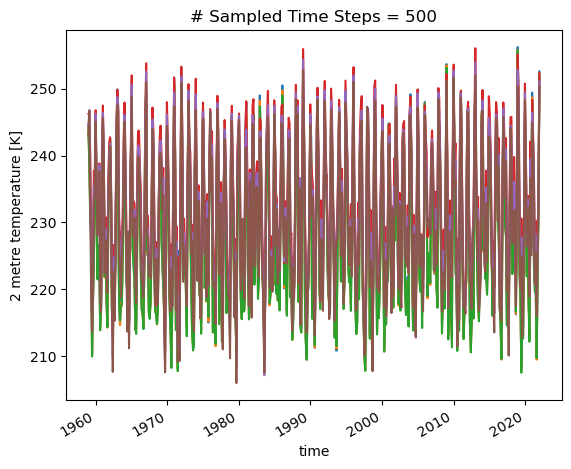

In [77]:
subsample(500)

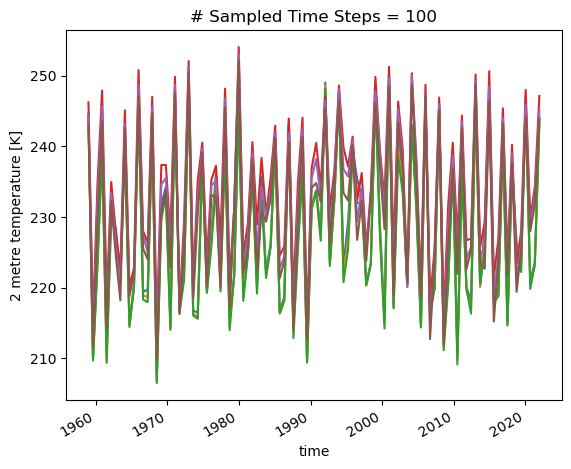

In [78]:
subsample(100)

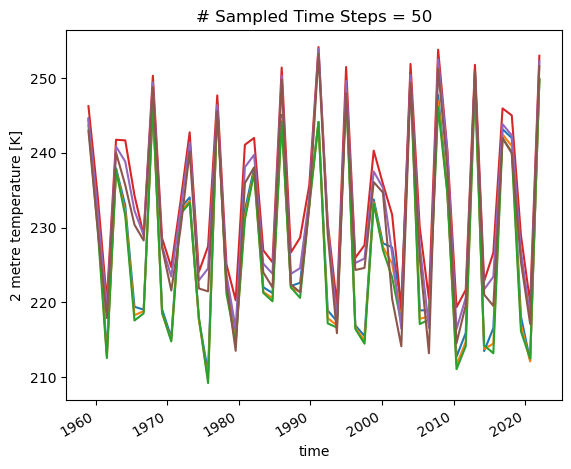

In [79]:
subsample(50)